### **Sentiment Analysis performed on dataset from Movie Review Data at [*IMDB Review*](https://www.tensorflow.org/datasets/catalog/imdb_reviews)** using Tensorflow Hub Text-embedding model by Google

In [ ]:
# Imports
import os
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.12.0
Eager mode:  True
Hub version:  0.13.0
GPU is available


In [ ]:
# Loading the training and testing data from Tensorflow Datasets
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:80%]', 'train[20%:]', 'test'),
    as_supervised=True)


In [ ]:
type(train_data), len(validation_data), len(test_data), len(train_data)

(tensorflow.python.data.ops.prefetch_op._PrefetchDataset, 20000, 25000, 20000)

In [ ]:
# Exploring the dataset
for example, label in train_data.take(5):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0
text:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. 

#### **Using the embedding model -**
*nnlm-en-dim128-with-normalization*

[Token based text embedding trained on English Google News 200B corpus](https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2)

In [ ]:
# Defining the embedding layer from tensorflow hub

embedding_url = 'https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2'
embedding_layer = hub.KerasLayer(embedding_url, input_shape=[], dtype=tf.string, trainable=True)


In [ ]:
embedding_layer(['I love roses', 'Rose is a flower'])

In [ ]:
# Designing the model for text-classification

model = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Dense(16, 'relu'),
    tf.keras.layers.Dense(1)
])


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 124,644,769
Trainable params: 124,644,769
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compiling the model

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# !mkdir tensor_log

In [ ]:
# logdir = '/content/tensor_log'
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
# Fitting the model with data

r = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1,
                   )

Epoch 1/10
40/40 [==============================] - 19s 324ms/step - loss: 0.6033 - accuracy: 0.5918 - val_loss: 0.4830 - val_accuracy: 0.7630
Epoch 2/10
40/40 [==============================] - 12s 298ms/step - loss: 0.3814 - accuracy: 0.8377 - val_loss: 0.2743 - val_accuracy: 0.8933
Epoch 3/10
40/40 [==============================] - 11s 267ms/step - loss: 0.2203 - accuracy: 0.9166 - val_loss: 0.1827 - val_accuracy: 0.9272
Epoch 4/10
40/40 [==============================] - 11s 279ms/step - loss: 0.1397 - accuracy: 0.9518 - val_loss: 0.1357 - val_accuracy: 0.9570
Epoch 5/10
40/40 [==============================] - 11s 281ms/step - loss: 0.0923 - accuracy: 0.9728 - val_loss: 0.1097 - val_accuracy: 0.9649
Epoch 6/10
40/40 [==============================] - 11s 270ms/step - loss: 0.0589 - accuracy: 0.9855 - val_loss: 0.0950 - val_accuracy: 0.9688
Epoch 7/10
40/40 [==============================] - 11s 271ms/step - loss: 0.0380 - accuracy: 0.9931 - val_loss: 0.0873 - val_accuracy: 0.9706

In [ ]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 4s - loss: 0.3837 - accuracy: 0.8692 - 4s/epoch - 89ms/step
loss: 0.384
accuracy: 0.869


In [ ]:
model.evaluate()

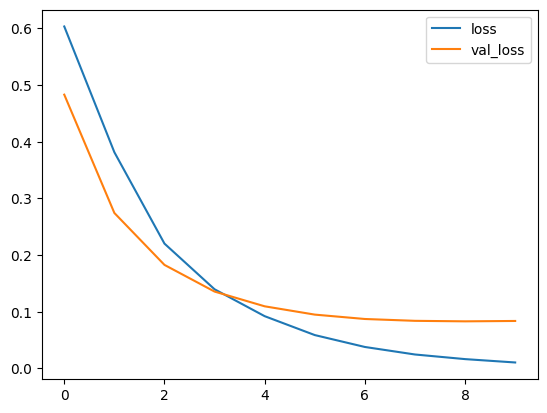

In [ ]:
# Plotting loss per iteration
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

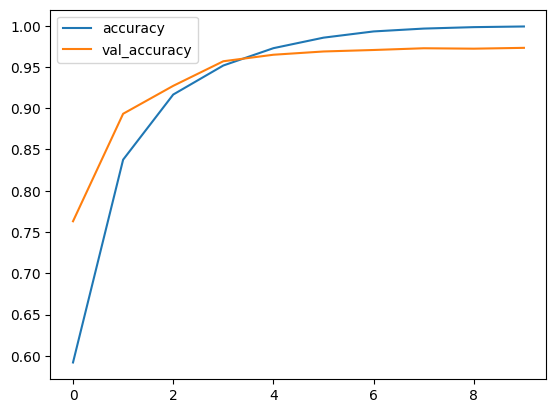

In [ ]:
# Plotting accuracy per iteration
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [ ]:
# Evaluating our model

print(model.evaluate(test_data.batch(1024)))

25/25 [==============================] - 3s 108ms/step - loss: 0.3837 - accuracy: 0.8692
[0.38372719287872314, 0.8691999912261963]


In [ ]:
# Model prediction score above 0 suggests that the sentiment is positive
model.predict(['Definitely watch this movie with your family!'])

1/1 [==============================] - 0s 55ms/step


array([[1.4899068]], dtype=float32)

In [ ]:
# Model prediction score below 0 suggests that the sentiment is negative
model.predict(['Kindly avoid watching this movie with your family as it is simply horrible!'])

1/1 [==============================] - 0s 38ms/step


array([[-5.0656075]], dtype=float32)